# Demo - Time Series Forecasting with TabPFN  🎉

Welcome to the demo of TabPFN for time series forecasting!

In this demo, we will show you how to use TabPFN for time series forecasting. Concretely, we will:

1. **Load time series data** -- you can also bring in time series data from your own problem
2. **Add features** -- we will use default features, but feel free to experiment with your own features!
3. **Perform prediction** -- zero-shot! 😉
4. **Visualize the forecasting results**


## Setup

In [12]:
!pip install tabpfn-time-series
# !pip install -e .

# for downloading datasets
!pip install datasets

## Load Time Series Data

In this demo, we will use the time series dataset from [Chronos Dataset](https://huggingface.co/datasets/autogluon/chronos_datasets) on HuggingFace. Also, we'll keep it short and work with just 2 time series from the dataset.

Feel free to explore other datasets by using the dataset names from Chronos Dataset on HuggingFace or even use time series data of your own problem.

In [14]:
dataset_metadata = {
    "monash_tourism_monthly": {"prediction_length": 24},
    "m4_hourly": {"prediction_length": 48},
}

dataset_choice = "monash_tourism_monthly"
num_time_series_subset = 2

In [15]:
from datasets import load_dataset
from autogluon.timeseries import TimeSeriesDataFrame

from tabpfn_time_series.data_preparation import to_gluonts_univariate, generate_test_X

prediction_length = dataset_metadata[dataset_choice]['prediction_length']
dataset = load_dataset("autogluon/chronos_datasets", dataset_choice)

tsdf = TimeSeriesDataFrame(to_gluonts_univariate(dataset['train']))
tsdf = tsdf[tsdf.index.get_level_values('item_id').isin(tsdf.item_ids[:num_time_series_subset])]
train_tsdf, test_tsdf_ground_truth = tsdf.train_test_split(prediction_length=prediction_length)
test_tsdf = generate_test_X(train_tsdf, prediction_length)

Let's take a look at the time series data.

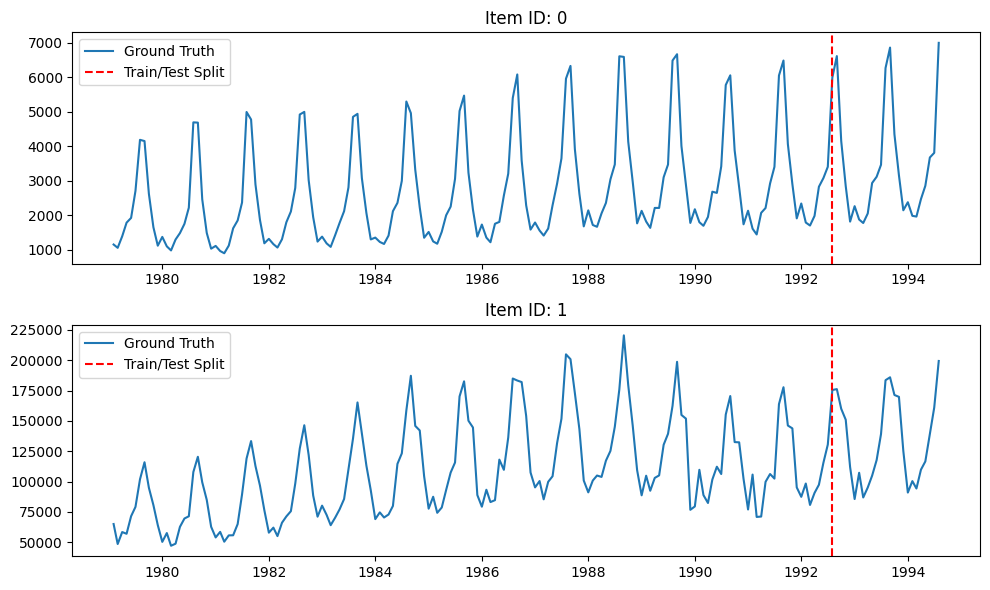

In [16]:
from tabpfn_time_series.plot import plot_actual_ts

plot_actual_ts(train_tsdf, test_tsdf_ground_truth)

## Adding Features

In our paper, we propose adding `running_index` and `calendar_features` to the table.

**Feel free to experiment with your own features!**

To do that, simply define your own feature functions and pass them to the `FeatureTransformer`.

In [17]:
from tabpfn_time_series import FeatureTransformer, DefaultFeatures

selected_features = [
    DefaultFeatures.add_running_index,
    DefaultFeatures.add_calendar_features,
]

train_tsdf, test_tsdf = FeatureTransformer.add_features(
    train_tsdf, test_tsdf, selected_features
)


Let's take a look at the tables (train and test) before we proceed to do predictions.

✅ Realize that we have added some features into the tables.

In [18]:
train_tsdf.head()

target  running_index  year  hour_of_day_sin  \
item_id timestamp                                                     
0       1979-01-31  1149.8700              0  1979              0.0   
        1979-02-28  1053.8002              1  1979              0.0   
        1979-03-31  1388.8798              2  1979              0.0   
        1979-04-30  1783.3702              3  1979              0.0   
        1979-05-31  1921.0252              4  1979              0.0   

                    hour_of_day_cos  day_of_week_sin  day_of_week_cos  \
item_id timestamp                                                       
0       1979-01-31              1.0     8.660254e-01             -0.5   
        1979-02-28              1.0     8.660254e-01             -0.5   
        1979-03-31              1.0    -8.660254e-01              0.5   
        1979-04-30              1.0     0.000000e+00              1.0   
        1979-05-31              1.0     1.224647e-16             -1.0   

                    day_of_month_sin  day_of_month_cos  day_of_year_sin  \
item_id timestamp                                                         
0       1979-01-31          0.106293          0.994335         0.495009   
        1979-02-28         -0.507666          0.861554         0.842101   
        1979-03-31          0.106293          0.994335         0.999404   
        1979-04-30         -0.106293          0.994335         0.885456   
        1979-05-31          0.106293          0.994335         0.524704   

                    day_of_year_cos  week_of_year_sin  week_of_year_cos  \
item_id timestamp                                                         
0       1979-01-31         0.868888          0.473094          0.881012   
        1979-02-28         0.539320          0.833602          0.552365   
        1979-03-31         0.034516          0.995734          0.092268   
        1979-04-30        -0.464723          0.866025         -0.500000   
        1979-05-31        -0.851284          0.526432         -0.850217   

                    month_of_year_sin  month_of_year_cos  
item_id timestamp                                         
0       1979-01-31           0.000000           1.000000  
        1979-02-28           0.540641           0.841254  
        1979-03-31           0.909632           0.415415  
        1979-04-30           0.989821          -0.142315  
        1979-05-31           0.755750          -0.654861

In [19]:
test_tsdf.head()

target  running_index  year  hour_of_day_sin  \
item_id timestamp                                                  
0       1992-08-31     NaN            163  1992              0.0   
        1992-09-30     NaN            164  1992              0.0   
        1992-10-31     NaN            165  1992              0.0   
        1992-11-30     NaN            166  1992              0.0   
        1992-12-31     NaN            167  1992              0.0   

                    hour_of_day_cos  day_of_week_sin  day_of_week_cos  \
item_id timestamp                                                       
0       1992-08-31              1.0     0.000000e+00              1.0   
        1992-09-30              1.0     8.660254e-01             -0.5   
        1992-10-31              1.0    -8.660254e-01              0.5   
        1992-11-30              1.0     0.000000e+00              1.0   
        1992-12-31              1.0     1.224647e-16             -1.0   

                    day_of_month_sin  day_of_month_cos  day_of_year_sin  \
item_id timestamp                                                         
0       1992-08-31          0.106293          0.994335        -0.868888   
        1992-09-30         -0.106293          0.994335        -1.000000   
        1992-10-31          0.106293          0.994335        -0.860214   
        1992-11-30         -0.106293          0.994335        -0.495009   
        1992-12-31          0.106293          0.994335         0.017261   

                    day_of_year_cos  week_of_year_sin  week_of_year_cos  \
item_id timestamp                                                         
0       1992-08-31    -4.950088e-01         -0.920906         -0.389786   
        1992-09-30    -1.836970e-16         -0.995734          0.092268   
        1992-10-31     5.099326e-01         -0.833602          0.552365   
        1992-11-30     8.688880e-01         -0.361242          0.932472   
        1992-12-31     9.998510e-01          0.122888          0.992421   

                    month_of_year_sin  month_of_year_cos  
item_id timestamp                                         
0       1992-08-31      -7.557496e-01          -0.654861  
        1992-09-30      -9.898214e-01          -0.142315  
        1992-10-31      -9.096320e-01           0.415415  
        1992-11-30      -5.406408e-01           0.841254  
        1992-12-31      -1.133108e-15           1.000000

## Prediction

Now, let's perform prediction.

We provide two options, `TabPFNMode.LOCAL` and `TabPFNMode.CLIENT`, as the backend for TabPFN.

- `TabPFNMode.LOCAL` uses your local machine to run TabPFN.
- `TabPFNMode.CLIENT` uses TabPFN's inference service provided by [tabpfn-client](https://github.com/automl/tabpfn-client)

For this demo, we'll use `TabPFNMode.CLIENT` to perform prediction. If you have not use the client before, you'll be prompted to create an account.

Note: if your machine doesn't have a GPU, using `TabPFNMode.CLIENT` is recommended -- must faster 😉.


In [20]:
from tabpfn_time_series import TabPFNTimeSeriesPredictor, TabPFNMode

predictor = TabPFNTimeSeriesPredictor(
    tabpfn_mode=TabPFNMode.CLIENT,
)

pred = predictor.predict(train_tsdf, test_tsdf)

  Welcome Back! Found existing access token, reusing it for authentication.
  Welcome Back! Found existing access token, reusing it for authentication.
Duration estimate: 2.205 seconds


Processing:   0%|          | [00:00<?]:01]

Duration estimate: 2.205 seconds


Processing: 100%|██████████| [00:02<00:00]
Processing: 100%|██████████| [00:02<00:00]


## Visualize the Results

Let's visualize the forecasting results.

Also, note that we provide both **point prediction** and **quantile prediction**, how amazing! 😄

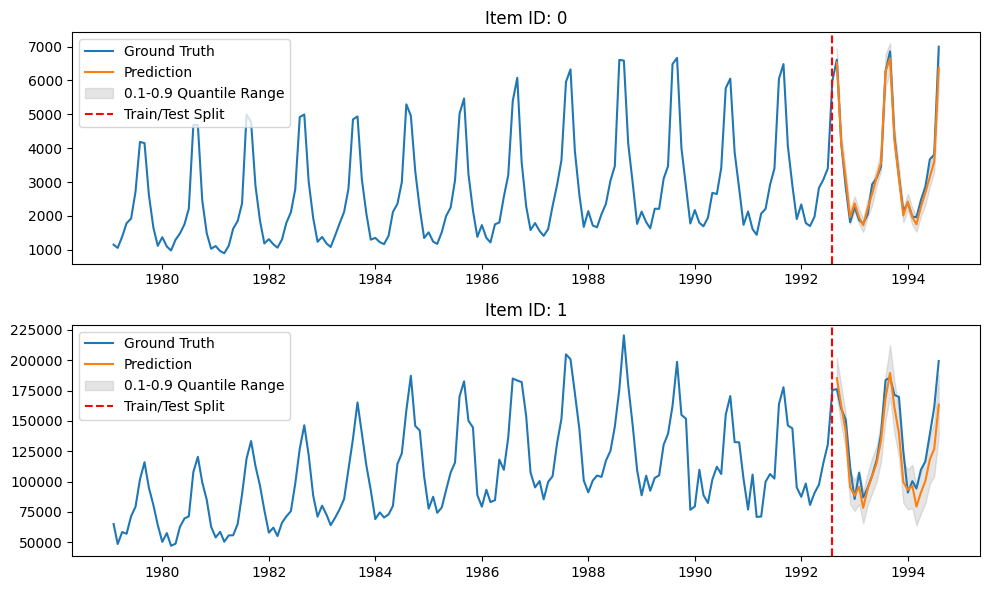

In [21]:
from tabpfn_time_series.plot import plot_pred_and_actual_ts

plot_pred_and_actual_ts(
    train=train_tsdf,
    test=test_tsdf_ground_truth,
    pred=pred,
)

In [22]:
pred.head()

target          0.1          0.2          0.3  \
item_id timestamp                                                        
0       1992-08-31  6527.899414  6122.431152  6269.360352  6368.829590   
        1992-09-30  4153.775391  3885.609619  3977.901855  4044.871094   
        1992-10-31  3089.239746  2853.894775  2936.594238  2994.673584   
        1992-11-30  1963.328979  1753.884155  1826.398071  1877.597656   
        1992-12-31  2371.709717  2135.548584  2222.235352  2281.053955   

                            0.4          0.5          0.6          0.7  \
item_id timestamp                                                        
0       1992-08-31  6451.040527  6527.899414  6604.597168  6687.769043   
        1992-09-30  4101.389648  4153.775391  4206.887207  4265.164062   
        1992-10-31  3043.089600  3089.239746  3136.241943  3188.472900   
        1992-11-30  1922.030884  1963.328979  2004.979492  2050.094482   
        1992-12-31  2328.547363  2371.709717  2413.676270  2458.116699   

                            0.8          0.9  
item_id timestamp                             
0       1992-08-31  6790.719238  6945.550293  
        1992-09-30  4338.817383  4455.012695  
        1992-10-31  3252.757324  3352.073975  
        1992-11-30  2104.083496  2180.963623  
        1992-12-31  2508.885498  2580.678223

# Feedback

Let us know what you think!

Write us at Discord: https://discord.gg/qK7AaXPN or just simply create an issue on [GitHub](https://github.com/liam-sbhoo/tabpfn-time-series/tree/main).

Thank you for trying out our method! 🎉
